In [1]:
#ignore
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats

from IPython.display import set_matplotlib_formats
%matplotlib inline

In [2]:
#ignore

set_matplotlib_formats('svg')
plt.rcParams["figure.figsize"] = (10, 8)
plt.rcParams.update({'font.size': 18})

## Introduction 

During the training steps, machine learning models learn how the _features_ (or inputs) are correlated with the _target_ variable you are trying to predict. If you are just trying to make predictions, without driving the inputs, then the difference between correlation and causation isn't important.

The [previous article](/pathological-demand-in-ridesharing-confounding-with-demand.html) looked at a hypothetical ridesharing application, where the number of rides booked _increase_ as price increases. This defies common sense: we expect as price goes up, the number of rides taken to decrease. Hidden in this statement is the unstated assumption that the demand remain the same. If we phrase it as the weekend nights which had big concerts playing we applied surge factors, and on Tuesday nights we didn't, it is not as surprising that low prices have low number of rides, because we charge low prices when there isn't much demand in the first place.

When setting a price policy, what we would _ideally_ like to do is ask:
> For this particular customer, how likely are they to book a ride if offered at price $p$?

That is often a tricky question to answer, because we only get to show a customer one price. If we think the only thing other than price that changes the liklihood of booking a ride is demand, then we can treat all customers at the same level of demand as interchangable. Once _controlling_ for demand, we see the usual relationship: as price increases, the chance of an individual booking a ride decreases, and hence the total number of rides decrease.

The technical name for this process is "controlling for the confounder", demand. For a ridesharing application, it is reasonably easy to measure demand by looking at the number of rides looked up, or the number of times the app is opened.  The question of what to control for, and what to leave alone, is the subject of _causal analysis_.

This article looks at a similar case of pricing, demand, and airline flights. Because airline flights can be booked through many different channels, we might not have a great measurement of demand, so we are not able to explicitly control for it. The instrumental variable technique is introduced instead.

# Flight bookings

As with the ridesharing problem, we will start this problem by simulating data. The models this time will just be linear models, which allow us to use the instrumental variables the cleanest way, using _two-stage least squares_.

We still have
* External demand: driven by the market, in units of price per ticket
* Gas prices: driven by the market, in units of price per barrel
* Price of a ticket: set by the airline, as well as costs of business (e.g. cost of gas)
* At a given price of a ticket and external demand, we can determine the number of tickets booked

In most applications, we would normalize the inputs (i.e. center the means around 0 and the standard deviations to 1). In this case, we are using unregularized linear models, so we don't get any benefit from normalization. To make the modeling simpler, we are dealing with macro-economic variables now over the course of the entire day. 

Let's start by looking at the external factors:

In [3]:
# ignore
np.random.seed(42)

In [4]:
# demand on each of the 365 days, in terms of average amount a 
# customer is willing to pay
external_demand = stats.gamma(loc=80, a=3, scale=5).rvs(365)

# Gas prices per day
gas_prices = stats.norm(loc=100, scale=10).rvs(365)

Now we can ask, for a given a ticket price and demand, how many seats can we expect to be booked? 

In [5]:
def num_booked(daily_ticket_price, daily_demand):
    num_days = len(daily_ticket_price)
    return 6000 + 3500 * daily_demand - 1800*daily_ticket_price + 150*np.random.normal(size=num_days) 

When gas is more expensive, airlines have to charge more for the flights to remain profitable. When demand is high, airlines charge more because they can. So let's make the daily price the airline charges increase with demand, but decrease with gas price:

In [6]:
ticket_price = 40 + external_demand + 0.3*(gas_prices - 100)

We still end up with the pretty strong correlation between demand and ticket price:

Text(0, 0.5, 'Demand')

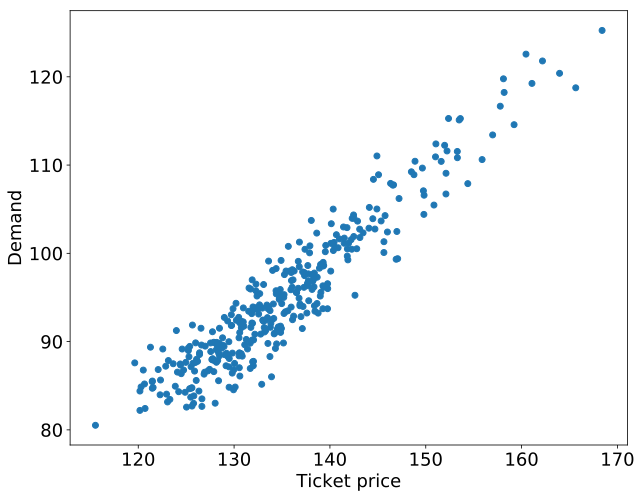

In [7]:
#ignore

plt.plot(ticket_price, external_demand, 'o')
plt.xlabel('Ticket price')
plt.ylabel('Demand')

Now let's look at the plot of ticket price vs number of bookings. We calculate the number of bookings using

In [8]:
num_bookings = num_booked(ticket_price, external_demand)

The plot (with trend line included) matches what we saw for the ridesharing application: as price increases, the number of booked flights also increase.

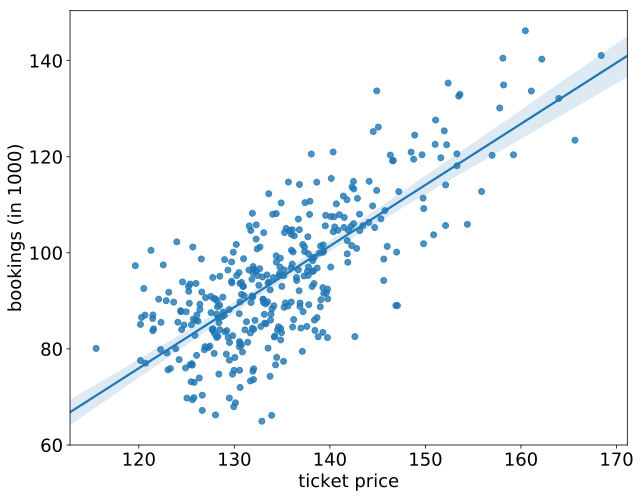

In [9]:
#ignore
df_booking = pd.DataFrame({'ticket price': ticket_price,
                           'bookings (in 1000)': num_bookings/1000,
                           'external_demand': external_demand,
                           'gas_price': gas_prices
                          })
sns.regplot('ticket price', 'bookings (in 1000)', data=df_booking);

## The counterfactual shuffle

The trend between price and bookings at the same level of demand is hidden in the observational data because of the strong correlation between demand and price. Since we know the relationship _in the simulation_, we could see what would have happened if we had taken these same prices and assigned them randomly:

In [10]:
random_ticket_pricing = np.random.permutation(ticket_price)
counterfactual_booking = num_booked(random_ticket_pricing, external_demand)

We see that the trend is now negative:

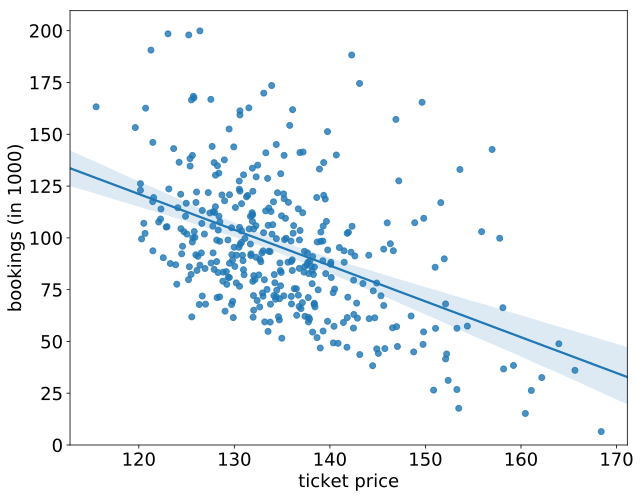

In [11]:
#ignore
df_booking = pd.DataFrame({'ticket price': random_ticket_pricing,
                           'bookings (in 1000)': counterfactual_booking/1000,
                           'external_demand': external_demand,
                           'gas_price': gas_prices
                          })

sns.regplot('ticket price', 'bookings (in 1000)', data=df_booking)
plt.ylim(0, );

As in the ridesharing case, we are not able to actually randomize the prices and run the "what-if" (or counterfactual) analysis, as we don't have the model of the behavior. In the ridesharing case, we could control for demand in a couple of ways:
- if we were willing to assume it was a linear model, we could add demand as one of the regressors.
- if we didn't want to assume a linear model, we could bucket the demand and then look at the behavior of price against bookings, so we would only be comparing the relationship at similar levels of demand.

In the ridesharing context, a direct measurement of demand makes sense. For an airline, it is a lot harder: people can be looking at tickets on multiple different websites. What if we couldn't measure demand (and therefore not control for it)? The next section explores how we can use the gas price as an _instrumental variable_.

## Gas price as an instrumental variable

The way we generated the data was using the following set of relationships:

In [12]:
#ignore
from graphviz import Digraph
# Create Digraph object
dot = Digraph(engine="neato")
dot.node('Gas price', pos='-1.5,0!')
dot.node('Demand', pos='1,1!')
dot.node('Price', pos='0,0!')
dot.node('Bookings', pos='2,0!')


# Add edge between 1 and 2
dot.edge('Demand', 'Price')
dot.edge('Demand', 'Bookings')
dot.edge('Price', 'Bookings')
dot.edge('Gas price', 'Price')

dot.render(format='png', filename='../images/pathological_demand/flight_dag');

<img alt="Process dag" src="images/pathological_demand/flight_dag.png" style="width:60%"/>

The only way the gas price entered into the problem was helping us set the price the customer saw. In fact, the only way the gas price can influence anything is by affecting the price of a ticket. Informally, this allows it to be a candidate for being an _instrumental variable_.

Instrumental variables are used to eliminate effects from omitted or non-measured effects. Informally, a variable is an _instrumental variable_ for X if it influences X, and the only way it influences the target variable is through X. In this case, the gas price is an instrument for the ticket price:

- The gas price influences the price at which tickets are offered,
- The gas price doesn't affect the number of bookings, _except_ to the degree it influences the ticket price,
- And critically, the gas price and demand are not correlated.

The last step, that the instrument (gas price) and the omitted varaibles (demand) are not correlated is the hardest one to convince yourself of. It is true in this case (we generated the simulated data), but it is much harder to convince yourself of this when using instrumental varaibles, as we don't actually have the demand data.

We will give the precise defintion and some references in the section [defining instrumental variables](#defining-instrumental-variables), but for now, let's work with the intuition. The price of a ticket is set by the (observed) price of gas, and the (unobserved) demand. If gas price and demand are uncorrelated, then we can use the gas prices and ticket prices, and regress one against another to determine the amount the ticket price increases per dollar increase in gas. The demand will average out! So let's say we find the ticket price increases by $\text{\$}$0.30 for every dollar increase in ticket price.

Now let's look at how the number of bookings corrleate with the gas price. At any given gas price, we will get a range of bookings, both because of random noise (which will cancel out), and because the price is also affected by demand. But at a given _gas price_, that will also cancel out, because _gas price_ and demand are uncorrelated. So let's say we find the number of bookings decreases by 540 for every dollar increase in ticket price.

The intuition is that increases in the price of gas caused the ticket price to go up by $\text{\$}$0.30, and that 30 cent increase caused the number of bookings to decrease by 540. Therefore we expect every 30 cent increase in ticket price to drop the bookings by 540, or every dollar increase in ticket price to drop the number of bookings by 540/0.3 = 1800!

The magic here is that we couldn't regress ticket price against the number of bookings, because ticket price was correlated with demand. If (and it is a big if!) gas price is not correlated with demand, but only with how willing the company is to supply flights at a given price, then demand averages out in the two regressions.

<br/>

<details>
    <summary><b>Math details for the simple case above</b></summary>
The idea is that price in the observed data comes from information about demand (not measured) and gas price:
$$ \text{price} = \alpha_0 + \alpha_g \times \text{(gas price)} + \alpha_d \times\text{(demand)}$$
The number of bookings depends on the price and the demand:
$$\text{num bookings} = \beta_0 + \beta_p \text{(price)} + \beta_d \times\text{(demand)}$$
We want to know $\beta_p$, which tells us how the number of bookings increase as we increase the price by a dollar (while holding demand fixed). Because of the law of supply and demand, we expect this to be negative.

We cannot observe demand, but if gas price and demand are uncorrelated, and we do a regression of _price_ vs _gas price_ we will find the equation
$$ \text{price} = A\times (\text{gas price}) + B = \alpha_g \times \text{(gas price)} + [\alpha_0 + \alpha_d \times \text{avg demand}]$$
We will know the values of $A$ and $B$ from doing the fit. Because we don't know demand, we cannot determine how much of the intercept $B$ is $\alpha_0$ and how much is $\alpha_d$. We can measure $A$, the coefficient of gas price in the regression, and $A$ is our best estimate at $\alpha_g$.

Now let's look at our bookings. We expand out price in terms of gas price and demand:
$$\text{num bookings} = (\beta_0 + \beta_p  \alpha_0) + \beta_p \alpha_g \times \text{(gas price)} + (\beta_p  \alpha_d + \beta_d) \times\text{(demand)}$$
When we regress this against gas price we get
$$\text{num bookings} = \beta_p \alpha_g \times \text{(gas price)} + [....] = C \text{(gas price) + D$$
i.e. the constant in this regression is $C = \beta_p \alpha_g$.

We can find $\beta_p$ by taking the ratio of $C/A = \beta_p \alpha_g / \alpha_g = \beta_p$.

</details>

If all the relationships are linear, we can determine the causal effect by looking at the ratio of coefficients in two separate regressions, and taking the coefficient of the instrumental variable. We have
$$\text{causal effect of ticket price increases on bookings} = \frac{\text{coef. of gas price on bookings}}{\text{coef. of gas price on ticket price}}$$

## Instrumental variables and two-stage least squares in action

We saw in our definition of the `num_booked` function that each dollar increase in price should lead to 1800 fewer bookings, at the same level of demand. Let's see how our instrumental approach recovers this!

In [13]:
from sklearn.linear_model import LinearRegression

model1 = LinearRegression().fit(gas_prices.reshape(-1,1), num_bookings)
model2 = LinearRegression().fit(gas_prices.reshape(-1,1), ticket_price)

bookings_per_ticket_dollar = (model1.coef_/model2.coef_)[0]
bookings_per_ticket_dollar

-1446.8353214928009

We don't get the answer exactly right with 365 data points (off by roughly 350 bookings in our estimate). To estimate the confidence in this answer, we should bootstrap our samples. However, we do much better than trying to run a regression of price on bookings directly. We already know from the graph that we will have the wrong sign, but it is interesting to see how far too it is:

In [14]:
model3 = LinearRegression().fit(ticket_price.reshape(-1,1), num_bookings)
print(model3.coef_[0])

1271.9610476494786


## Defining Instrumental Variables

More complicated causal problems require doing additional controlling on variables to stop information from leaking. The lecture notes from [CMU](https://www.stat.cmu.edu/~cshalizi/402/lectures/23-causal-estimation/lecture-23.pdf) are a pretty good technical overview of the process, and define instrumental variables in more complicated situations as well. [Angrist and Kruger](https://economics.mit.edu/files/18) give a description that is better suited for economists, and they have a pretty broad range of examples of instrumental variables. Finally the [UC Davis](http://cameron.econ.ucdavis.edu/e240a/ch04iv.pdf) notes split the difference in terms of technical level and intuition.

If we have a set of variables $S$ that we need to control for to determine the effect of $X$ (e.g. ticket price) on $Y$ (e.g. number of bookings) then we need

1. The instrumental variable influences $X$ after controlling for all the things in $X$.
2. All the unblocked paths the instrument has for affecting $Y$ have an ingoing arrow to $X$. In particular, the instrument is conditionally independent of all the other unobserved or omitted variables (conditioned on S).

This is the more formal notion of "the only influence the instrument has on the outcome is via its affect on X". The definition here is for quick reference only, for complete details consult the references above.

## Critiques of instrumental variables

Instrumental variables generally offer pretty weak correlation with the thing they are trying to measure, which means we get large variances. With the simulated data set above, we saw errors of approximately 20% on our estimates of the number of bookings lost per dollar ticket price increase. For linear models, the technique is unbiased (i.e. you will approach the right answer as you collect more data), but the confidence intervals shrink slowly.

Determining that the instrument is independent of other omitted variables (such as demand, in this case) is often significiantly harder. Usually this is a form of reasonableness argument, as the omitted variables are not recorded, necessitating the need for an instrument in the first place. The [Davis notes](http://cameron.econ.ucdavis.edu/e240a/ch04iv.pdf) give an example in determining the effect of price on vegetable sales. Both are influenced by demand, which is hard to measure, but price is affected by supply and demand. Anything that affects supply without affecting demand would by a good instrumental variable (and is the example I borrowed from for this example). The example there was "growing conditions", which would affect supply, but not demand.

[Angrist and Kruger](https://economics.mit.edu/files/18) have a section on "potential pitfalls". One of the interesting ones is that attempts to use more than one instrument on a varaible (in an attempt to boost the "weak instrument" problem) can be a source of bias. The second is worth reading in detail.

## Example of instrumental variables in other applications

Angrist and Kruger also collect a nice table, with references, to different instrumental variables for observational data. Recall our problem was to know, given observational data, what the effect of increasing the ticket price by a dollar would be at the same demand, and we found gas price was the instrument that allowed us to ignore the omitted variable (demand). 

Another relatively clean example is that the effect of taking a drug can be confounded by all sorts of factors, such as other medical conditions. Often times, getting access to the drug is an instrument -- placing someone in the control or placebo group of a drug trial ensures that they have _access_ to the drug or the placebo; it doesn't ensure that they actually comply with the program. So even when we have randomized experiments, the randomizations often only give us instruments.

Here are a sample of some other outcomes, variables to control, and instrumental variables:

| Outcome | Variable to change | Instrumental variable | Observed/Randomized | 
|---|---|---|---|
| Num bookings | Ticket price | Gas price | Observed |
| Recovery | Taking drug | Access to drug | Observed | 
| Wages | Minimum Wage | Differing states (sim. to diff-in-diff) | Observed |
| Birth weight | Maternal smoking | State cigarette taxes | Observed |
| Test scores | Hours of study | Access to prep materials | Randomized | 

## Summary

Similar to the rideshare problem, we saw that the number of bookings made increased with price, because both price and bookings increase with demand. In the ridesharing case, we controlled for demand directly. In this case, we assume that we cannot measure demand directly, and use the technique of _instrumental variables_ instead.

Ultimately, the quested we are intersted in answering is:
> How many seats would we have booked at price $p$, holding everything else the same?

Our simple regression fails because comparing high ticket prices to low ticket prices is also comparing times of high demand to times of low demand.

Our simple example doesn't have a lot of variables. In our case, an instrumental variable for the effect of ticket price on number of seats booked must:
1. affect the ticket price
2. only affect the number of bookings through the effect it has on ticket price

The gas price, affecting supply and not demand, is one such example.

* We could do _two_ linear regressions
  - ticket price vs gas price: `ticket price = A gas + B`
  - num bookings vs gas price: `num bookings = C gas + D`
* The ratio of the coefficients $C/A$ gives us the effect of increasing ticket price by one dollar on bookings, while holding demand constant.
* This technique depends on the instrumental variable being independent of the omitted varaible, which is hard to verify since we typically don't have the omitted variable.
* The technique is noisy for instruments that are only weakly correlated with their inputs, and many variables are weak.
* The approach taken in the ridesharing article, controlling for the confounder, is generally preferred, and leads to better estimates (i.e. smaller confidence intervals).

### Acknowledgements
Thanks to Vivien Tsao and Joyce Lee for participating in discussion about this problem, after reviewing the flight example in Business Data Science. 

### Resources

* ["Business Data Science"](https://www.amazon.com/Business-Data-Science-Combining-Accelerate-ebook/dp/B07HRVYTHV) (M. Taddy), chapter 5 on experimentation introduces the idea of pathological demand, and has a good treatment of instrumental variables. Flight example inspired by this chapter.
* [Causal Estimation lectuers](https://www.stat.cmu.edu/~cshalizi/402/lectures/23-causal-estimation/lecture-23.pdf) for CMU's Advanced Analytics class has a section introducing instrumental variables
* ["Instrumental Variables and the Search for Identification: From Supply and Demand to Natural Experiments"](https://economics.mit.edu/files/18) is a introductory review of the instrumental variable technique.
* ["An empirical analysis of delays in the Turkish Airlines network"](https://www.researchgate.net/publication/320157728_An_empirical_analysis_of_delays_in_the_Turkish_Airlines_network#pf5) for an actual study using (different) instrumental variables but real data on a flight problem.
* ["Simpson's Paradox"](/simpsons-rule.html)
* ["Instrumental Variables"](http://cameron.econ.ucdavis.edu/e240a/ch04iv.pdf) section of an unknown set of lecture notes from Econ 240A at UC Davis.
* ["Ridesharing"], the first article in this series